# **Análise do Dataset Movie Lens Small**

# Informações Gerais

## Conhecendo o dataset


Trata-se do conjunto de dados [Movie Lens Small](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip), contendo classificação de filmes do serviço de recomendação [movielens](http://movielens.org).

### Informações do [README](data/ml-latest-small/README.txt) do dataset

O dataset contém **100.836 avaliações** e **3.683 *rótulos*** para **9.742 filmes**. Os dados foram criados por **610 usuários**. Cada usuário avaliou pelo menos 20 filmes.

Os arquivos estão em formato *CSV*, com uma única linha de cabeçalho. Colunas que contenham vírgula estão escapadas com aspas duplas. Codificação é UTF-8.

- **User Ids**: São consistentes entre os arquivos `ratigns.csv` e `tags.csv` (mesmo *id* se refere a um mesmo usuário nestes dois arquivos)
- **Movie Ids**: Apenas filmes com ao menos uma avaliação ou *rótulo* estão inclusos no dataset. Ids são consistentes entre os arquivos `ratings.csv`, `tags.csv`, `movies.csv` e `links.csv`

#### `ratings.csv`
> 100.836 avaliações

Cada linha do arquivo representa uma avaliação de um filme por um usuário, no seguinte formato:

    userId,movieId,rating,timestamp

As avaliações estão em uma escala de *5 estrelas*, com incrementos de *0,5 estrelas* (0,5 - 5.0). *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `tags.csv`
> 3.683 *rótulos*

Cada linha do arquivo representa um *rótulo* atribuído a um filme por um usuário, no seguinte formato:

    userId,movieId,tag,timestamp

*Rótulos* são metadados dos filmes, formadas em geral por palavras únicas ou frases curtas. *Timestamp* é uma valor em [Unix time](https://en.wikipedia.org/wiki/Unix_time).

#### `movies.csv`
> 9.742 filmes

Cada linha do arquivo representa um filme, no seguinte formato:

    movieId,title,genres

Os títulos dos filmes podem conter erros e inconsistências. O ano de lançamento está incluso entre parêntesis.

Os gêneros estão em uma lista separadas por pipe (`|`), e são selecionados dos seguintes valores:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

#### `links.csv`
> 9.742 *links*

Cada linha do arquivo representa um filme, contendo *links* para outras fontes de dados de filmes, no seguinte formato:

    movieId,imdbId,tmdbId

*movieId* é um identificador dos filmes usado pelo [movielens](https://movielens.org)<br />
*imdbId* é um identificador dos filmes usado pelo [IMDb](http://www.imdb.com)<br />
*tmdbId* é um identificador dos filmes usado pelo [TMDB](https://www.themoviedb.org)

### Diagrama dos Dados

A partir da especificação dos dados, podemos traçar um diagrama para melhor visualizar a relação entre as diferentes tabelas. Isto nos ajudará no momento de validar e limpar os dados carregados.

![](https://github.com/dieguim-ifsp-posCD/D1AED/blob/evaluation-01/avaliacoes/20210513-avaliacao01/recursos/20210524-diagrama_dados.png?raw=1)

## Importação do Dataset

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
DATAPATH = 'https://raw.githubusercontent.com/dieguim-ifsp-posCD/D1AED/evaluation-01/avaliacoes/20210513-avaliacao01/data/ml-latest-small'

ratings_df = pd.read_csv(f'{DATAPATH}/ratings.csv')
tags_df    = pd.read_csv(f'{DATAPATH}/tags.csv')
movies_df  = pd.read_csv(f'{DATAPATH}/movies.csv')
links_df   = pd.read_csv(f'{DATAPATH}/links.csv')

In [73]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [74]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [75]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [76]:
links_df.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


## Consistência dos dados

#### Ratings

##### Linhas e Colunas

In [77]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 100836
colunas_esperadas = ['userId', 'movieId', 'rating', 'timestamp']

(num_linhas, num_colunas) = ratings_df.shape
lista_colunas = list(ratings_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Ratings estão corretos')

Número de linhas `100836` e lista de colunas `['userId', 'movieId', 'rating', 'timestamp']` do DataFrame Ratings estão corretos


In [78]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **rating** é *real*, conforme esperado, pois as avaliações estão em um intervalo de 0,5 estrelas
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

##### userId

In [79]:
# Verificação da quantidade de usuários únicos
# De acordo com especificação, todos usuários avaliaram pelo menos 20 filmes, logo todos devem estar presentes no DataFrame
usuarios_esperados = 610

num_usuarios = len(ratings_df.userId.unique())

assert num_usuarios == usuarios_esperados, 'Número de usuários não condiz com o esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está correto')
print(f'{(num_usuarios/usuarios_esperados * 100):.2f}% dos usuários realizaram avaliação de algum filme')

Número de usuários `610` do DataFrame está correto
100.00% dos usuários realizaram avaliação de algum filme


##### movieId

In [80]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem avaliação (alguns filmes podem possuir apenas rótulos),
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(ratings_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos uma avaliação')

Número de filmes `9724` no DataFrame está dentro do limite máximo esperado
99.82% dos filmes receberam pelo menos uma avaliação


##### rating

In [81]:
# Verificação das avaliações (mais importante)
# De acordo com a especificação, as notas estão no intervalo [0.5, 5.0], com saltos de 0.5
avaliacoes_esperadas = np.arange(0.5, 5.1, 0.5) # Colocamos um valor ligeiramente maior que 5.0 como 'stop' para que o '5.0' seja incluido

lista_avaliacoes = ratings_df.rating.unique()

assert set(lista_avaliacoes).issubset(set(avaliacoes_esperadas)), 'Lista de avaliações possui valores diferentes do esperado'

print(f'Avaliações `{lista_avaliacoes}` dos registros do DataFrame estão dentro do conjunto esperado')

Avaliações `[4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]` dos registros do DataFrame estão dentro do conjunto esperado


#### Tags

##### Linhas e Colunas

In [82]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 3683
colunas_esperadas = ['userId', 'movieId', 'tag', 'timestamp']

(num_linhas, num_colunas) = tags_df.shape
lista_colunas = list(tags_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Tags estão corretos')

Número de linhas `3683` e lista de colunas `['userId', 'movieId', 'tag', 'timestamp']` do DataFrame Tags estão corretos


In [83]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **userId** e **movieId** são *inteiros*, como esperado para Ids
- **tags** é *object*, conforme esperado, pois as tags são *strings*
- **timestamp** é *inteiro*, como esperado para um valor de *Unix time*

##### userId

In [84]:
# Verificação da quantidade de usuários únicos
# A especificação não diz que todos os usuários rotularam filmes,
# portanto podemos avaliar apenas se o número de usuários é menor que o máximo do dataset
usuarios_maximo = 610

num_usuarios = len(tags_df.userId.unique())

assert num_usuarios <= usuarios_esperados, 'Número de usuários é maior que o máximo esperado'

print(f'Número de usuários `{num_usuarios}` do DataFrame está dentro do limite máximo esperado')
print(f'{(num_usuarios/usuarios_maximo * 100):.2f}% dos usuários rotularam algum filme')

Número de usuários `58` do DataFrame está dentro do limite máximo esperado
9.51% dos usuários rotularam algum filme


Aqui já podemos notar que o número de usuários presentes no DataFrame de *tags* é consideravelmente pequeno.

##### movieId

In [85]:
# Verificação quantidade de filmes avaliados
# A especificação não diz que todos os filmes possuem rótulos,
# portanto iremos avaliar apenas se o número de ids de filmes é menor do que o total do dataset
filmes_maximo = 9742

num_filmes = len(tags_df.movieId.unique())

assert num_filmes <= filmes_maximo, 'Número de filmes é maior do que o máximo esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está dentro do limite máximo esperado')
print(f'{(num_filmes/filmes_maximo * 100):.2f}% dos filmes receberam pelo menos um rótulo')

Número de filmes `1572` no DataFrame está dentro do limite máximo esperado
16.14% dos filmes receberam pelo menos um rótulo


O número de filmes *rotulados* também é consideravelmente pequeno.

##### tags

In [86]:
# Verificação dos rótulos
# De acordo com a especificação, os rótulos em geral são palavras únicas ou frases curtas

# Separa o campo tags em uma lista de palavras
lista_palavras = tags_df.tag.str.split()

# Verifica quantos elementos contém cada lista (ou seja, quantas palavras o rótulo possui) e agrega os valores
palavras_tag = lista_palavras.apply(len).value_counts().to_frame().reset_index()
palavras_tag.columns = ['Palavras na Tag', 'Número de Registros']
palavras_tag['% Registros'] = round((palavras_tag['Número de Registros'] / palavras_tag['Número de Registros'].sum())*100,1)
palavras_tag['%Registros Acumulados'] = palavras_tag['% Registros'].cumsum()

palavras_tag

,Palavras na Tag,Número de Registros,% Registros,%Registros Acumulados
0,1,2282,62.0,62.0
1,2,1057,28.7,90.7
2,3,275,7.5,98.2
3,4,43,1.2,99.4
4,5,16,0.4,99.8
5,7,4,0.1,99.9
6,6,3,0.1,100.0
7,16,1,0.0,100.0
8,10,1,0.0,100.0
9,8,1,0.0,100.0


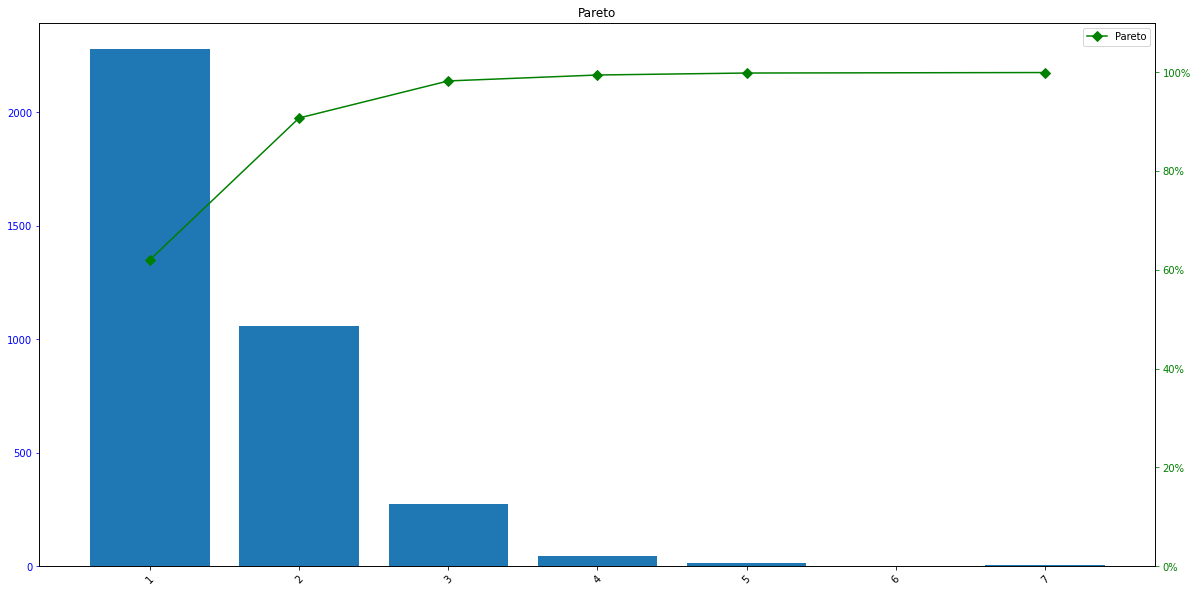

In [87]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def Pareto(df, Type, Count, CumPercent):
  # Cria o barplot e define os dados os eixos, a cor das barras, titulo do gráfico
  fig, ax = plt.subplots(figsize=(20,10))
  ax.bar(df[Type], df[Count], color="C0")
  ax.set_title("Pareto")

  # Eixo secundário
  ax2 = ax.twinx()

  # Cria a Curva de Pareto no eixo secundário
  ax2.plot(df[Type], df[CumPercent], color="G", marker="D", ms=7, label='Pareto')
  ax2.yaxis.set_major_formatter(PercentFormatter())

  # Configurações dos eixos 
  ax.tick_params(axis="y", colors="B")
  ax2.tick_params(axis="y", colors="G")
  ax2.set_ylim([0,110])

  # Ajusta a inclinação dos labels do eixo x
  for tick in ax.get_xticklabels():
      tick.set_rotation(45)

  # Finalmente mostra o grafico definido acima
  plt.legend() # para mostrar a legenda
  plt.show()

Pareto(palavras_tag[:6], 'Palavras na Tag', 'Número de Registros', '%Registros Acumulados')

Aqui é uma avaliação um pouco subjetiva, mas como visto no gráfico de Pareto, a maioria dos registros de rótulos (mais de 98%) possui até 3 palavras, o que cumpre com a especificação de um *rótulo*. 

É possível que os *outliers* (que contenham *muitas* palavras) não sejam termos que cumpram a função de *rótulo*.

#### Movies

##### Linhas e Colunas

In [88]:
# Verificação do número de linhas e lista de colunas, de acordo com a especificação do dataset
linhas_esperadas = 9742
colunas_esperadas = ['movieId', 'title', 'genres']

(num_linhas, num_colunas) = movies_df.shape
lista_colunas = list(movies_df.columns)

assert num_linhas == linhas_esperadas, 'Número de linhas não condiz com o esperado'
assert num_colunas == len(colunas_esperadas), 'Número de colunas não condiz com o esperado'
assert lista_colunas == colunas_esperadas, 'Colunas inconsistentes com o esperado'

print(f'Número de linhas `{num_linhas}` e lista de colunas `{lista_colunas}` do DataFrame Movies estão corretos')

Número de linhas `9742` e lista de colunas `['movieId', 'title', 'genres']` do DataFrame Movies estão corretos


In [89]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Não há nenhum valor nulo para nenhuma das colunas do DataFrame

O tipo de todas as colunas é condizente com o que esperamos:
- **movieId** é *inteiros*, como esperado para Ids
- **title** é *object*, conforme esperado, pois os títulos são *strings*
- **genres** é *object*, conforme esperado, pois os gêneros são *strings*

##### movieId

In [90]:
# Verificação quantidade de filmes
filmes_esperados = 9742

num_filmes = len(movies_df.movieId.unique())

assert num_filmes == filmes_esperados, 'Número de filmes não condiz com o esperado'

print(f'Número de filmes `{num_filmes}` no DataFrame está correto de acordo com a especificação')

Número de filmes `9742` no DataFrame está correto de acordo com a especificação


##### title

In [91]:
# Verificação dos títulos
# Como títulos são strings, vamos verificar apenas se possuem alguma repetição ou valor vazio

duplicados = movies_df[movies_df.title.duplicated()]
vazios = movies_df[movies_df.title == '']

print(f'Existe `{len(duplicados)}` filmes com títulos duplicados. E `{len(vazios)}` com título vazio')

Existe `5` filmes com títulos duplicados. E `0` com título vazio


##### genres

In [92]:
generos_esperados = [
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western", "(no genres listed)"
]

# Separa o campo genres em uma lista de gêneros
lista_generos = movies_df.genres.str.split("|")

# Transforma a lista de listas de gêneros em uma só Series com todos os valores
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
todos_generos = pd.Series([x for _list in lista_generos for x in _list])

# Vamos verificar se os gêneros no nosso dataset estão todos dentro da lista esperada
try:
    assert set(todos_generos.unique()).issubset(generos_esperados), 'Existe gêneros que não são esperados'
except Exception as e:
    print(type(e), e)
    
# Quais gêneros não são esperados?
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos,generos_esperados))

<class 'AssertionError'> Existe gêneros que não são esperados
Gêneros no dataset diferentes do esperado: ['Children' 'IMAX']


Existem dois gêneros presentes no *dataset* que não são esperados, de acordo com a especificação: **Children** e **IMAX**

No caso de **Children**, parece que houve um erro na especificação do *dataset*. Vamos sustituir o valor esperado de **Children's** para **Children**

In [93]:
try:
    generos_esperados[generos_esperados.index("Children's")] = "Children"
except:
    print("Children's já foi substituido. Continuando...")
    
print('Gêneros no dataset diferentes do esperado:', np.setdiff1d(todos_generos,generos_esperados))

Gêneros no dataset diferentes do esperado: ['IMAX']


Agora só temos o gênero **IMAX** que não está especificiado.

Vamos ver quantas vezes ele ocorre

In [94]:
(todos_generos == 'IMAX').sum()

158

#### Links

Os atributos deste dataset não nos parece necessário para as análises desejadas. Desta forma, iremos desconsiderá-lo a partir de agora

#### *userId* em `ratings` e `tags`

In [95]:
# Verificar se os usuários de tags são um subconjunto dos usuários de ratings,
# uma vez que este possui a lista completa de usuários

usuarios_ratings = ratings_df.userId.unique()
usuarios_tags = tags_df.userId.unique()

assert set(usuarios_tags).issubset(set(usuarios_ratings)), 'Existem usuários em `tags` que não estão presentes em `ratings`'

print(f'Os {len(usuarios_tags)} usuários em `tags` são um subconjunto dos {len(usuarios_ratings)} usuários em `ratings`')

Os 58 usuários em `tags` são um subconjunto dos 610 usuários em `ratings`


#### *movieId* em `ratings`, `tags` e `movies`

In [96]:
# Verificar se os Ids de filmes em ratings e tags são um subconjunto dos filmes em movies

filmes_ratings = ratings_df.movieId.unique()
filmes_tags = tags_df.movieId.unique()
filmes_movies = movies_df.movieId.unique()

assert set(filmes_ratings).issubset(set(filmes_movies)), 'Existem filmes em `ratings` que não estão presentes em `movies`'
assert set(filmes_tags).issubset(set(filmes_movies)), 'Existem filmes em `tags` que não estão presentes em `movies`'

print(f'Os {len(filmes_ratings)} filmes em `ratings` e os {len(filmes_tags)} em `tags` são um subconjunto dos {len(filmes_movies)} filmes do DataFrame `movies`')

Os 9724 filmes em `ratings` e os 1572 em `tags` são um subconjunto dos 9742 filmes do DataFrame `movies`


In [97]:
# Verificar se todos os filmes em movies receberam ao menos uma avaliação ou rótulo

assert set(np.concatenate((filmes_ratings, filmes_tags))) == set(movies_df.movieId), 'Conjunto de movieId nos DataFrames `ratings` e `tags` difere dos Ids no DataFrame `movies`'

print('O conjunto de movieId nos DataFrames `ratings` e `tags` é o mesmo dos filmes no DataFrame `movies`')

O conjunto de movieId nos DataFrames `ratings` e `tags` é o mesmo dos filmes no DataFrame `movies`


#### Avaliações e rótulos duplicados de um mesmo filme por determinado usuário

In [98]:
# Um mesmo usuário realizou mais de uma avaliação de um determinado filme?
avaliacoes_duplicadas = ratings_df[ratings_df.duplicated(subset=['userId', 'movieId'])]

# Um mesmo usuário atribuiu um determinado rótulo mais de uma vez para um determinado filme?
rotulos_duplicados = tags_df[tags_df.duplicated(subset=['userId', 'movieId', 'tag'])]

assert len(avaliacoes_duplicadas) == 0, 'Existem avaliações duplicadas'
assert len(rotulos_duplicados) == 0, 'Existem rótulos duplicados'

print('Nenhuma avaliação ou rótulo duplicado no dataset')

Nenhuma avaliação ou rótulo duplicado no dataset


# Pré-processamento

## Rótulos com muitas palavras

In [334]:
tags_df[lista_palavras.apply(len) > 4]

,userId,movieId,tag,timestamp
412,106,4896,Everything you want is here,1467566944
485,161,52287,Something for everyone in this one... saw it w...,1176498861
587,318,48698,the catholic church is the most corrupt organi...,1276006189
621,319,364,Oscar (Best Music - Original Score),1461351919
739,424,608,based on a true story,1457900882
840,424,3186,based on a true story,1457846002
1112,474,457,based on a TV show,1137784717
1164,474,648,based on a TV show,1138137584
1181,474,818,based on a TV show,1137375996
1201,474,912,start of a beautiful friendship,1137202319


As tags com mais de 4 palavras serão mantidas para análise



## Títulos duplicados

In [335]:
# Nome dos filmes repetidos
title_filmes_duplicados = duplicados['title']

# Df com as informações dos filmes repetidos com os dados do "movies_df"
lista_filmes_duplicados = movies_df.query('title in @title_filmes_duplicados')

# Id dos filmes repetidos
movieId_filmes_duplicados = lista_filmes_duplicados['movieId'].values

# Quantidade de Notas atribuidas aos movieId com dados do "ratings_df"
lista_filmes_duplicados.set_index('movieId', inplace = True)
lista_filmes_duplicados['Ratings_count'] = ratings_df.query('movieId in @movieId_filmes_duplicados').movieId.value_counts()
lista_filmes_duplicados.sort_values(by =['title'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,title,genres,Ratings_count
movieId,,,
6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,16
838,Emma (1996),Comedy|Drama|Romance,31
32600,Eros (2004),Drama,2
2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,5
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,52


Para evitar problemas de separação de dados, os ID's serão unificados conforme relação abaixo

> Confessions of a Dangerous Mind (2002) - movieId: 6003 (old: 144606)

> Emma (1996) - movieId: 838 (old: 26958)

> Eros (2004) - movieId: 32600 (old: 147002)

> Saturn 3 (1980)	- movieId: 2851 (old: 168358)

> War of the Worlds (2005) - movieId: 34048 (old:64997)

In [336]:
# Lista movieId Excluidos
movie_id_excluidos = [144606, 26958, 147002, 168358, 64997]

# Função de conversão
def conversao_movieId(num):
  if num == 144606:
    return 6003
  elif num == 26958:
    return 838
  elif num == 147002:
    return 32600
  elif num == 168358:
    return 2851
  elif num == 64997:
    return 34048
  else:
    return num

# Deletar id duplicados - movies_df
movies_df.drop((movies_df.query('movieId in @movie_id_excluidos').index), inplace = True, axis = 0)
duplicados_movies = len(movies_df[movies_df.title.duplicated()])

# Conversão de id - ratings_df
ratings_df['movieId'] = ratings_df['movieId'].map(conversao_movieId)
duplicados_ratings = len(ratings_df.query('movieId in @movie_id_excluidos'))

# Conversão tags_df
tags_df['movieId'] = tags_df['movieId'].map(conversao_movieId)
duplicados_tags = len(ratings_df.query('movieId in @movie_id_excluidos'))

# Verificação dos movie_id excluidos
print(f'Exitem {duplicados_movies} filmes com o movieId excluido no movies_df')
print(f'Exitem {duplicados_ratings} filmes com o movieId excluido no ratings_df')
print(f'Exitem {duplicados_tags} filmes com o movieId excluido no tags_df')

Exitem 0 filmes com o movieId excluido no movies_df
Exitem 0 filmes com o movieId excluido no ratings_df
Exitem 0 filmes com o movieId excluido no tags_df


## Gêneros não especificados
### IMAX

In [337]:
# Separar os generos por colunas
generos = movies_df['genres'].str.get_dummies()

# Juntar informações do movies_df com os generos separados por coluna
movies_df_generos = pd.concat([movies_df, generos], axis = 1)
movies_df_generos.drop('genres',axis =1, inplace = True)

print(f'Quantidade de filmes com genero IMAX: {movies_df_generos.query("IMAX == 1").shape[0]}\n\n')
movies_df_generos.head()

Quantidade de filmes com genero IMAX: 158




,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Embora o genero IMAX não esteja listado na documentação do dataset, essa informação não altera as análises. Dessa forma o genero IMAX será tratado como um genero válido

## Decisões

> **Quantidade de dados**: Todos os datasets possuem todas as colunas completas

> **Tipo de dados**: Os dados estão com o formato correto

> **Outliers**:


*   Tag: Optou-se por manter as tags com mais de 4 palavras

> **Tratamento dos dados**:

*   Filmes Duplicados: 5 filmes estavam com o título duplicado - Optou-se por unificar os id para evitar problemas de análises

*   Genres IMAX: O genero "IMAX" não constava na documentação do arquivo, optou-se por manter essa informação



# Análise Exploratória

## 1 – Existe alguma correlação entre o ano de lançamento do filme e sua avaliação média (média de ratings)?

In [338]:
# Separar o ano do titulo
ano_movies = movies_df.copy()
ano_movies['ano'] = ano_movies['title'].str.split('(').str.get(-1).str.split(')').str.get(0)

# Converter ano para int
ano_movies['ano'] = pd.to_numeric(ano_movies['ano'], errors='coerce')

# Verificar tipo de dados
ano_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9737 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9737 non-null   int64  
 1   title    9737 non-null   object 
 2   genres   9737 non-null   object 
 3   ano      9724 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB


In [339]:
# Filmes sem ano definido

filmes_sem_ano = ano_movies[ano_movies['ano'].isna()]
print(f'Existem {filmes_sem_ano.shape[0]} filmes sem a informação do ano\n\n')
filmes_sem_ano

Existem 13 filmes sem a informação do ano




,movieId,title,genres,ano
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [340]:
# Juntando o ano com as notas
rating_ano_movies = ratings_df.copy()
rating_ano_movies = rating_ano_movies[['movieId', 'rating']].merge(ano_movies[['movieId', 'ano']], on = 'movieId', how = 'left')

# Criando um DF com a media das notas por ano
rating_medio_por_ano = rating_ano_movies[['ano', 'rating']].groupby('ano').mean()
rating_medio_por_ano['count'] = rating_ano_movies[['ano', 'rating']].groupby('ano').count()
rating_medio_por_ano = rating_medio_por_ano.rename_axis('ano').reset_index()
rating_medio_por_ano

,ano,rating,count
0,1902.0,3.500000,5
1,1903.0,2.500000,2
2,1908.0,4.000000,1
3,1915.0,2.000000,1
4,1916.0,3.600000,5
...,...,...,...
101,2014.0,3.512879,1320
102,2015.0,3.410386,1088
103,2016.0,3.387261,785
104,2017.0,3.578091,461


Text(0.5, 1.0, 'Média de votos dos filmes em relação ao ano')

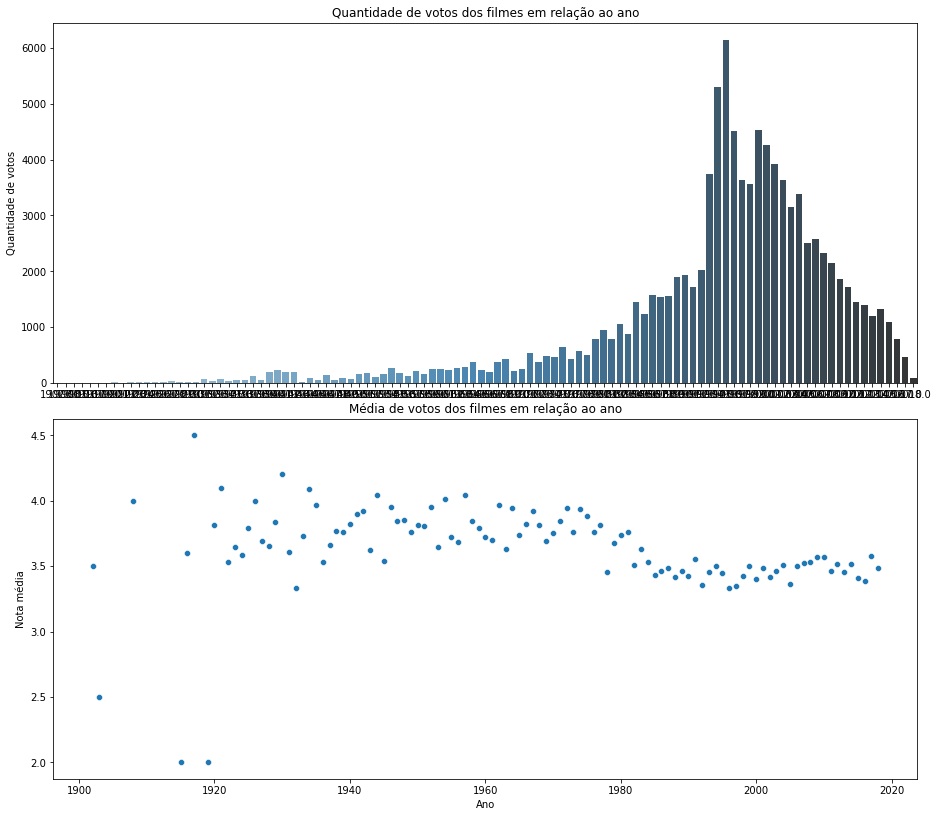

In [341]:
import seaborn as sns

fig = plt.figure(figsize=(12,10))

#Gráfico de Barra ([OFF]NÃO CONSEGUI TIRAR O EIXO X)
eixo = fig.add_axes([0, 0.55, 1, 0.5])
eixo = sns.barplot(x = 'ano', y = 'count', data = rating_medio_por_ano, palette="Blues_d")
eixo.set(ylabel = 'Quantidade de votos', xlabel = '')
eixo.set_title('Quantidade de votos dos filmes em relação ao ano')

# Gráfico de Dispersão
eixo2 = fig.add_axes([0, 0, 1, 0.5])
eixo2 = sns.scatterplot(x = 'ano', y = 'rating', data = rating_medio_por_ano, palette="Blues_d")
eixo2.set(ylabel = 'Nota média', xlabel = 'Ano')
eixo2.set_title('Média de votos dos filmes em relação ao ano')

In [342]:
rating_medio_por_ano.corr().round(3)

,ano,rating,count
ano,1.000,-0.158,0.667
rating,-0.158,1.000,-0.289
count,0.667,-0.289,1.000


A tabela de correlação indica que a nota média dos filmes tem uma correlação negativa muito fraca em relação ao ano de lançamento (-0.158).

O gráfico de dispersão indica que as notas dos filmes mais antigos possuem uma média distante dos demais valores. Isso ocorre devido a baixa quantidade de avaliações que esses filmes tiveram. 

A partir de 1940 a variação das notas começam a diminuir, de modo que as notas começam a ter um comportamento mais linear. O pico de avaliações ocorrem em torno dos filmes dos anos 2000.

De 1980 até 2000 as notas médias passam de em torno de 4.0 para 3.5, indicando uma variação negativa. Dos anos 2000 até 2020 as notas médias se mantem estáveis visualmente.

## 2 – Qual o grupo mais disperso, o de usuários que avaliaram ou o de usuários que rotularam filmes?


[OFF] Não sei se entendi a pergunta, vou levar em conta a dispersão da quantidade de vezes que um usuário avaliou um filme ou tageou ele

In [343]:
# Criando os DF de userId pela quantidade de vezes que o usuário avaliou um filme
userId_quantidade_de_ratings = ratings_df[['userId','movieId']].groupby('userId').count()

# Criando os DF de userId pela quantidade de vezes que o usuário colocou uma tag no filme
userId_quantidade_de_tags = tags_df[['userId','movieId']].groupby('userId').count()

# DF comparando valores de TAGS e RATINGS

# Count = Quantidade de usuários que tiveram "interação" (seja avaliação ou tag)
# Mean  = Média de inserções no dataframe
# STD   = Desvio Padrão de inserções no dataframe
# CV    = Coeficiente de Variação (STD / Mean)

comparação_tags_e_ratings = pd.DataFrame({'Count': [userId_quantidade_de_tags.shape[0], userId_quantidade_de_ratings.shape[0]],
                                          'Mean': [round(userId_quantidade_de_tags.mean()[0],2), round(userId_quantidade_de_ratings.mean()[0],2)],
                                          'STD'  : [round(userId_quantidade_de_tags.std()[0],2), round(userId_quantidade_de_ratings.std()[0],2)] }, index = ['Tags','Ratings'])
comparação_tags_e_ratings['CV'] = round(comparação_tags_e_ratings['STD'] / comparação_tags_e_ratings['Mean'],2)
comparação_tags_e_ratings

,Count,Mean,STD,CV
Tags,58,63.5,215.12,3.39
Ratings,610,165.3,269.48,1.63


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 0, '')]

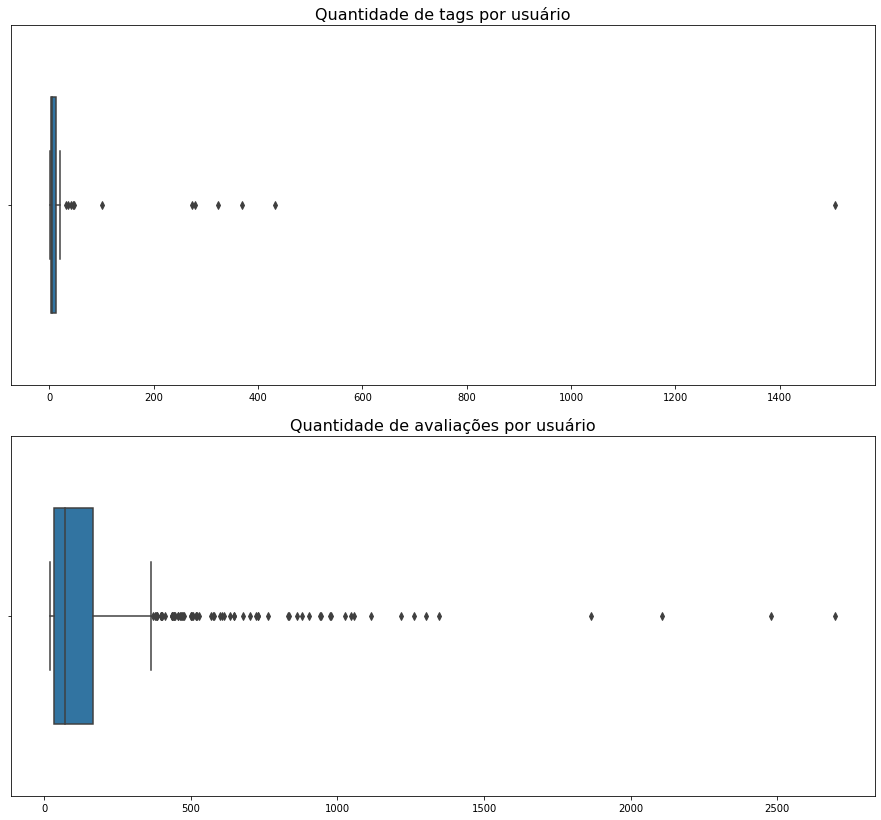

In [344]:
fig = plt.figure(figsize=(12,10))

#BoxPlot - Quantidade de Tags
eixo = fig.add_axes([0, 0.57, 1, 0.5])
eixo = sns.boxplot(userId_quantidade_de_tags.movieId, width = 0.6)
eixo.set_title('Quantidade de tags por usuário', fontsize = 16)
eixo.set(xlabel = '')

#BoxPlot - Quantidade de ratings
eixo2 = fig.add_axes([0, 0, 1, 0.5])
eixo2 = sns.boxplot(userId_quantidade_de_ratings.movieId, width = 0.6)
eixo2.set_title('Quantidade de avaliações por usuário', fontsize = 16)
eixo2.set(xlabel = '')


A presença de um usuário que colocou tag em mais de 1400 filmes distorce bastante os valores de média e desvio padrão desse grupo de usuários, de modo que o Coeficiente de variação é mais alto quando comparado com os usuários que avaliaram os filmes.

A análise dos Boxplot permite ver que existem muito mais usuários que avaliam os filmes que estão fora dos limites do gráfico em relação aos usuários que colocam tag. 

Essas duas análises permite indicar que a distribuição da quantidade de "interações" é maior nos usuários que avaliaram os filmes, ou seja, a dispersão dos valores é maior nos avaliadores em relação aos que colocam Tag

## 3 – Qual a categoria rotulada mais frequente?

In [414]:
# Juntando o DF de rótulos com a quantidade de tags usando movieId como chave
categorias_rotuladas = movies_df_generos.set_index('movieId')
categorias_rotuladas = pd.concat([categorias_rotuladas,(tags_df[['movieId','tag']].groupby('movieId').count())], axis = 1)
categorias_rotuladas.drop('title', axis = 1, inplace = True)
categorias_rotuladas.head(3)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0


In [413]:
# Criando Dicionário relacionando Generos com quantidade de tags
qtd_tags_por_rotulos = {}
for i in categorias_rotuladas.columns:
  qtd_tags_por_rotulos[i] = categorias_rotuladas[categorias_rotuladas[i] == 1].sum()[-1]

# Transformando Dicionário em DF
qtd_tags_por_rotulos = pd.DataFrame(qtd_tags_por_rotulos.values(), index = qtd_tags_por_rotulos.keys(), columns = ['Tags'])
qtd_tags_por_rotulos.sort_values(by='Tags', ascending= False).head(3)

,Tags
Drama,2095.0
Comedy,1154.0
Thriller,1099.0


A categoria Drama foi a mais rotulada com 2.095 Tags atribuidas

## 4 – Como estão distribuídas as avaliações ao longo do tempo?

## 5 -

## 6 -

## 7 -

## 8 -

## 9 -

## 10 -